# Python version of `runme.m` to make IC/OBCS for ISOMIP+

Original was matlab script from Yoshihiro Nakayama


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
Nx=240; #number of longitude cells      
Ny=42; #number of latitude cells        
Nz=37; #number of MITgcm vertical cells # When changing this you need to change SIZE.h as well !! 
nPx=10; #number of MITgcm processes to use in x direction 
nPy=2; #number of MITgcm processes to use in y direction 
delX =2.0*10e3;
delY =2.0*10e3;  
delZ =20; #thickness of vertical levels
icefront_position_ratio=0.8; 
ice_thickness=100;
rho_ice=917;
rho_water=1028.14;
di=rho_ice/rho_water;
        
# MITgcm initial and lateral boundary conditions
iniSalt   = 33.8; # initial salinity (PSU) (Since 1,2,3 layers are in the same in z)

iniTheta  = -1.9; # initial potential temperature (deg C)
  
mlDepth   = 30.; # mixed layer depth (m)        

obcSalt  = 34.4; # open boundary salinity (PSU)
obcTheta =  -1.9; # open boundary potential temperature (deg C)
#mlDepth  = 120.; # mixed layer depth (m)
mlSalt   = 33.4; # open boundary salinity (PSU)
mlTheta  = -1.9; # open boundary potential temperature (deg C)
obcUvel  = -0.0; # open boundary velocity (m/s)        
        
y2s=31536000; # year to seconds conversion, i.e., seconds per year

# # bedrock/bathymetry
# hmax=1000;
# trough_depth=200;
# deltah=300;
# sea_level=900;

# Bathymetry
# create lat,long
xxx=np.arange((delX/2)+160*2000,(Nx*delX)+160*2000+1, delX)
yyy=np.arange((delY/2)-1*2000,(Ny*delY)-1*2000+1, delY)    
xxx, yyy = np.meshgrid(xxx,yyy);

xxxmin=np.min(xxx);
xxxmax=np.max(xxx);
yyymin =np.min(yyy);
yyymax =np.max(yyy);

#Read ice thickness data
filename='Ocean1_input_geom_v1.01.nc';
path = '/home/156/cy8964/MITgcm/verification/ocean1/'
z_bot2 = xr.open_dataset(path+filename).lowerSurface
z_base2 = xr.open_dataset(path+filename).bedrockTopography
z_surf2 = xr.open_dataset(path+filename).upperSurface
Ground_c2 = xr.open_dataset(path+filename).groundedMask
# these have shape 80x480 so need to reduce into 42 x 240 (the two outer y ones are zeros)
z_bot = np.zeros([Ny,Nx])
z_base = np.zeros([Ny,Nx])
z_surf = np.zeros([Ny,Nx])
Ground_c = np.zeros([Ny,Nx])

for i in np.arange(1,Ny-1):
    for j in np.arange(Nx):
        z_bot[i,j]=(z_bot2[2*(i-1),2*(j)]+z_bot2[2*(i-1)+1,2*(j)+1])/2.0; #average of diagonal pairs (4 boxes turns into one)
        z_base[i,j]=(z_base2[2*(i-1),2*(j)]+z_base2[2*(i-1)+1,2*(j)+1])/2.0;
        z_surf[i,j]=(z_surf2[2*(i-1),2*(j)]+z_surf2[2*(i-1)+1,2*(j)+1])/2.0;
        Ground_c[i,j]=(Ground_c2[2*(i-1),2*(j)]+Ground_c2[2*(i-1)+1,2*(j)+1])/2.0;
        if(Ground_c[i,j]>0.1):
            Ground_c[i,j]=1

    

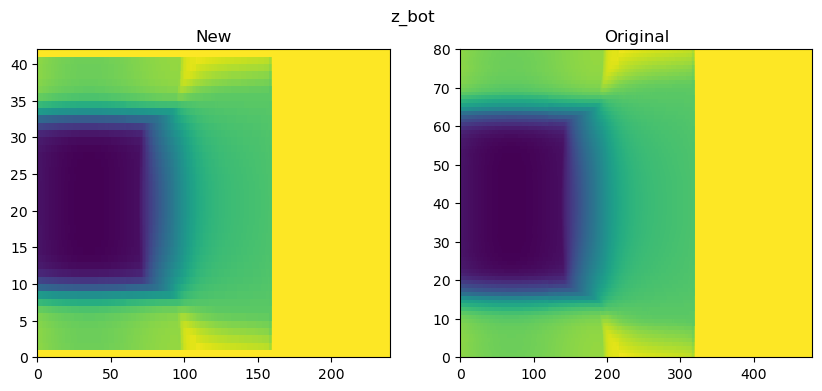

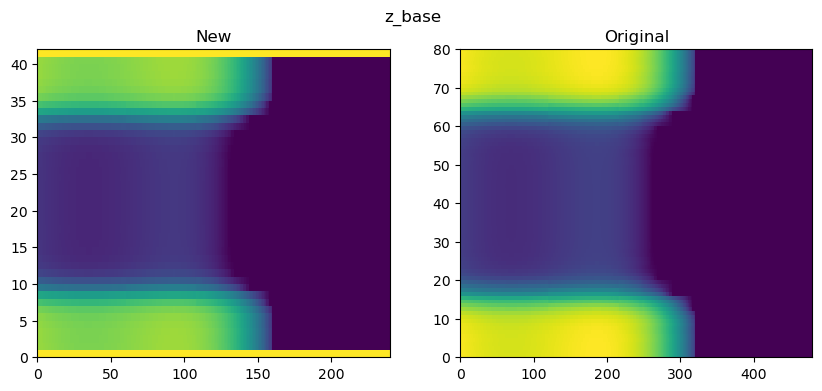

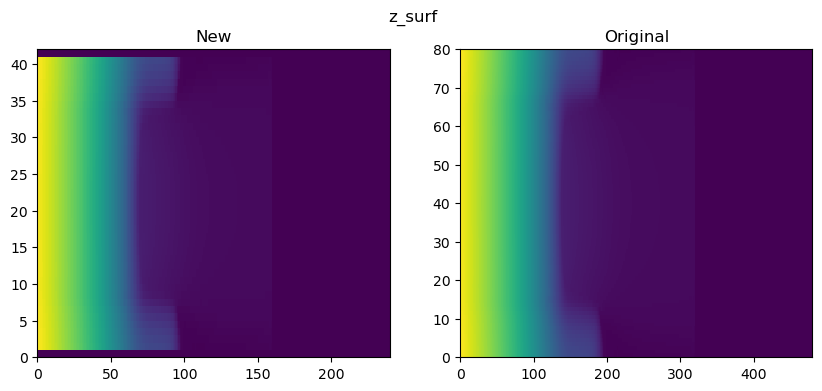

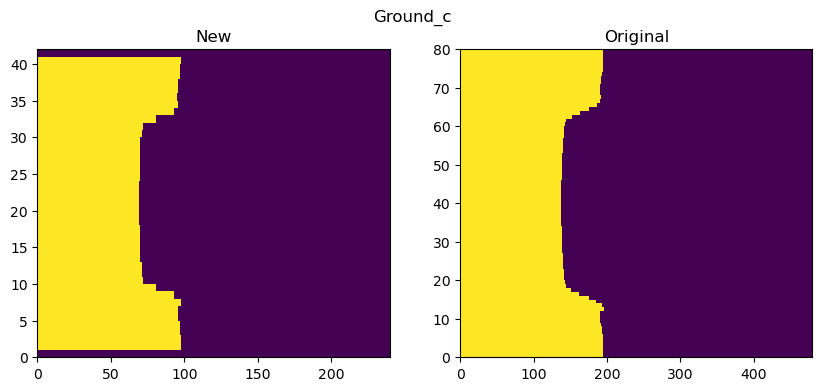

In [4]:
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
axes[0].pcolormesh(z_bot)
axes[1].pcolormesh(z_bot2)
axes[0].set_title('New')
axes[1].set_title('Original')
fig.suptitle('z_bot')
plt.show()
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
axes[0].pcolormesh(z_base)
axes[1].pcolormesh(z_base2)
axes[0].set_title('New')
axes[1].set_title('Original')
fig.suptitle('z_base')
plt.show()
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
axes[0].pcolormesh(z_surf)
axes[1].pcolormesh(z_surf2)
axes[0].set_title('New')
axes[1].set_title('Original')
fig.suptitle('z_surf')
plt.show()
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
axes[0].pcolormesh(Ground_c)
axes[1].pcolormesh(Ground_c2)
axes[0].set_title('New')
axes[1].set_title('Original')
fig.suptitle('Ground_c')
plt.show()

In [5]:
# Create Bathymetry    
bathymetry=np.zeros([Ny,Nx]);
for i in np.arange(1,Ny-1):
    for j in np.arange(Nx):
        bathymetry[i,j]=z_base[i,j];
        if (bathymetry[i,j]<-720.):
            bathymetry[i,j]=-720.

    
    
#Ice Geometry
#put ice_thickness constant layer of ice over the bathymetry, unless it floats: 
thickness=np.zeros([Ny,Nx]);
for i in np.arange(1,Ny-1):
    for j in np.arange(Nx):
        thickness[i,j]=z_surf[i,j]-z_bot[i,j]
    

Text(0.5, 1.0, 'Thickness')

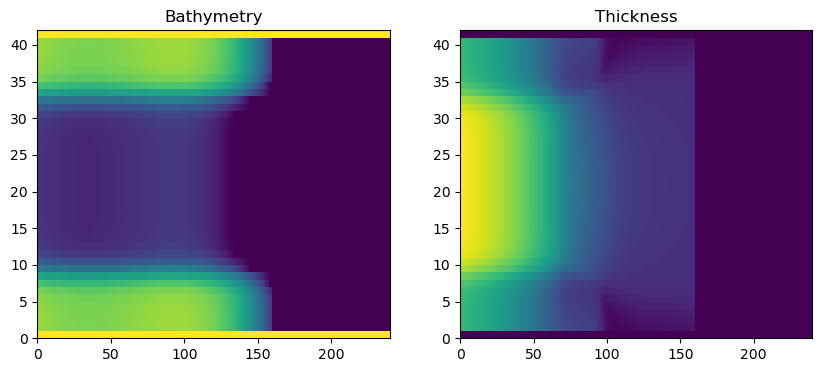

In [6]:
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
axes[0].pcolormesh(bathymetry)
axes[1].pcolormesh(thickness)
axes[0].set_title('Bathymetry')
axes[1].set_title('Thickness')


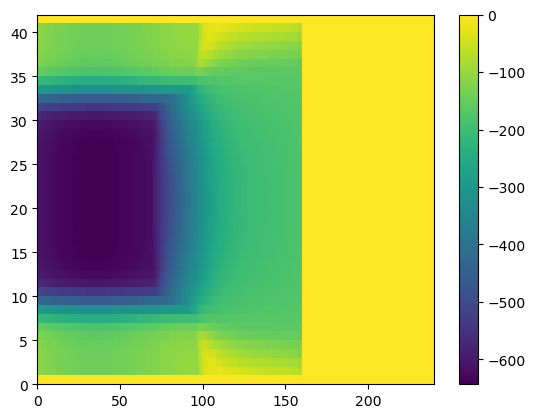

In [7]:
#figure out ice shelf (if floating or grounded): 
iceshelf_mask = np.where(-di*thickness>bathymetry, np.zeros([Ny,Nx]), np.ones([Ny,Nx]))

ice_mask= np.where(((xxx-xxxmin)/(xxxmax-xxxmin)) >icefront_position_ratio, np.zeros([Ny,Nx]), np.ones([Ny,Nx])) 
iceshelf_mask = np.where(((xxx-xxxmin)/(xxxmax-xxxmin)) >icefront_position_ratio, np.zeros([Ny,Nx]), iceshelf_mask) 

draft = np.where(iceshelf_mask !=1, -di*thickness, bathymetry)
draft = np.where(ice_mask !=1, np.zeros_like(draft), draft)
plt.pcolormesh(draft)
plt.colorbar()

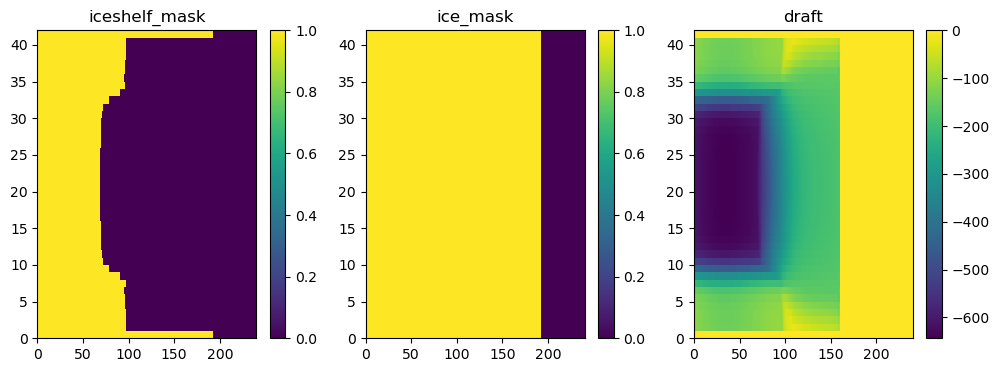

In [8]:
fig, axes = plt.subplots(ncols = 3, figsize = (12,4))

cs = axes[0].pcolormesh(iceshelf_mask)
axes[0].set_title('iceshelf_mask')
plt.colorbar(cs, ax = axes[0])
cs = axes[1].pcolormesh(ice_mask)
axes[1].set_title('ice_mask')
plt.colorbar(cs, ax = axes[1])
cs = axes[2].pcolormesh(draft)
axes[2].set_title('draft')
plt.colorbar(cs, ax = axes[2])


In [9]:
runfolder = '/home/156/cy8964/MITgcm/verification/ocean1/run-R22-warm-utide'

In [10]:
config = 'WARM' # 'COLD'

In [11]:
#save bathymetry and bedrock in run directory
bathymetry.astype('>f4').tofile(runfolder+'/bathymetry.bin')
draft.astype('>f4').tofile(runfolder+'/icetopo.bin')

In [12]:
# initial salinity
S=iniSalt*np.ones([Nx,Ny,Nz]);
for i in np.arange(Nx):
    for j in np.arange(Ny):
        for k in np.arange(Nz):
            if config == 'COLD':
                S[i,j,k]=33.8+(34.5-33.8)*(k-1)/(Nz-2); #COLD
            if config == 'WARM':
                S[i,j,k]=33.8+(34.7-33.8)*(k-1)/(Nz-2); #WARM    
S = S.T
S.astype('>f4').tofile(runfolder+'/Salt.bin')

# initial temperature
T=iniTheta*np.ones([Nx,Ny,Nz]);
for i in np.arange(Nx):
    for j in np.arange(Ny):
        for k in np.arange(Nz):
            if config == 'COLD':
                T[i,j,k]=-1.9+(-1.9-(-1.9))*(k-1)/(Nz-2); #COLD
            if config == 'WARM':
                T[i,j,k]=-1.9+(1.0-(-1.9))*(k-1)/(Nz-2); #WARM
T = T.T
T.astype('>f4').tofile(runfolder+'/Theta.bin')
    
# initial velocity
z=np.zeros([Nz,Ny,Nx]);
z.astype('>f4').tofile(runfolder+'/Uvel.bin')
z.astype('>f4').tofile(runfolder+'/Vvel.bin')

# initial sea surface height
Z=np.zeros([Nx,Ny]);
rho_t=np.zeros([Nx,Ny]);
#modifying initial
for i in np.arange(Nx):
    for j in np.arange(1,Ny-1):
        rho_t[i,j]=(((31.2-27.21)*(-z_bot[j,i])/720+27.21)+27.21)/2.;
        Z[i,j]=Z[i,j]+(-z_bot[j,i]*(1000+rho_t[i,j]-1027.21)/(1027.21))*1.0;    
Z = Z.T
Z.astype('>f4').tofile(runfolder+'/Etan.bin')
        
# salinity boundary conditions
S2=iniSalt*np.ones([Ny,Nz])+1.0;
for j in np.arange(Ny):
    for k in np.arange(Nz):
        if config == 'COLD':
            S2[j,k]=33.8+(34.5-33.8)*(k-1)/(Nz-2); #COLD;
        if config == 'WARM':
            S2[j,k]=33.8+(34.7-33.8)*(k-1)/(Nz-2); #WARM   
S2 = S2.T
S2.astype('>f4').tofile(runfolder+'/OBs.bin')

# temperature boundary conditions
T2=iniTheta*np.ones([Ny,Nz])+1.0;
for j in np.arange(Ny):
    for k in np.arange(Nz):
        if config == 'COLD':
            T2[j,k]=-1.9+(-1.9-(-1.9))*(k-1)/(Nz-2); #COLD
        if config == 'WARM':
            T2[j,k]=-1.9+(1.0-(-1.9))*(k-1)/(Nz-2); #WARM
T2 = T2.T
T2.astype('>f4').tofile(runfolder+'/OBt.bin')

# zonal velocity boundary conditions
U=obcUvel*np.ones([Nz,Ny]);
U.astype('>f4').tofile(runfolder+'/OBu.bin')

# zero boundary conditions
Z=np.zeros([Nz,Ny]);
Z.astype('>f4').tofile(runfolder+'/zeros.bin')


## Check files

### Added .T's to flip into nz, ny, nx format (same as exisitng ones)

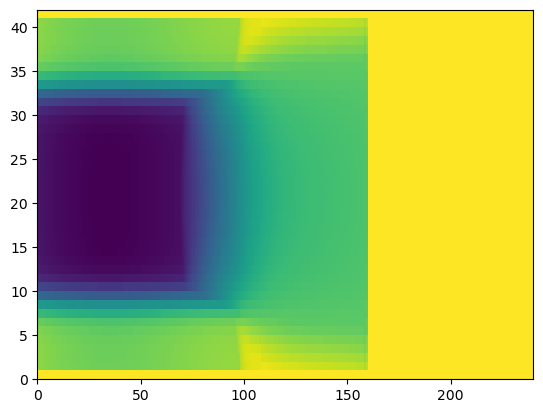

In [127]:
bin_file = 'icetopo.bin'
nx = 24*10    # number of gridpoints in x-direction
ny = 21*2    # number of gridpoints in y-direction
nz = 37
h = np.fromfile('/home/156/cy8964/MITgcm/verification/ocean1/run-HJ99-warm/'+bin_file, '>f4').reshape(ny, nx)
plt.pcolormesh(h)

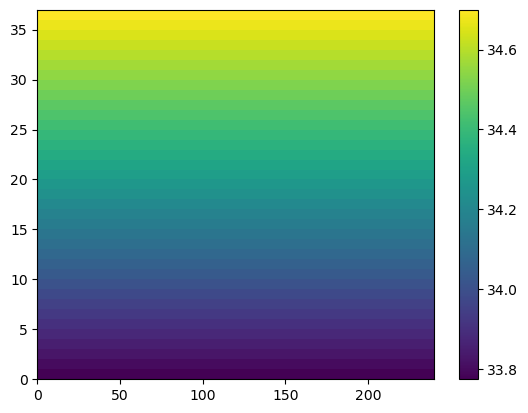

In [128]:
bin_file = 'Salt.bin'
nx = 24*10    # number of gridpoints in x-direction
ny = 21*2    # number of gridpoints in y-direction
nz = 37
h = np.fromfile('/home/156/cy8964/MITgcm/verification/ocean1/run-HJ99-warm/'+bin_file, '>f4').reshape(nz, ny, nx)
plt.pcolormesh(h[:,10,...])
plt.colorbar()

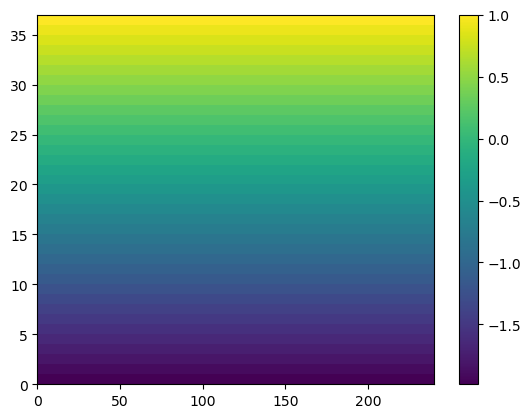

In [129]:
bin_file = 'Theta.bin'
nx = 24*10    # number of gridpoints in x-direction
ny = 21*2    # number of gridpoints in y-direction
nz = 37
h = np.fromfile('/home/156/cy8964/MITgcm/verification/ocean1/run-HJ99-warm/'+bin_file, '>f4').reshape(nz, ny, nx)
plt.pcolormesh(h[:,10,...])
plt.colorbar()

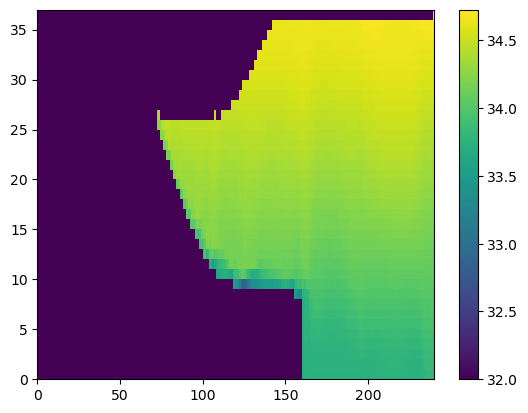

In [130]:
bin_file = 'Salt.bin'
nx = 24*10    # number of gridpoints in x-direction
ny = 21*2    # number of gridpoints in y-direction
nz = 37
h = np.fromfile('/home/156/cy8964/MITgcm/verification/ocean1/run2/'+bin_file, '>f4').reshape(nz, ny, nx)
plt.pcolormesh(h[:,10,...],vmin = 32)
plt.colorbar()

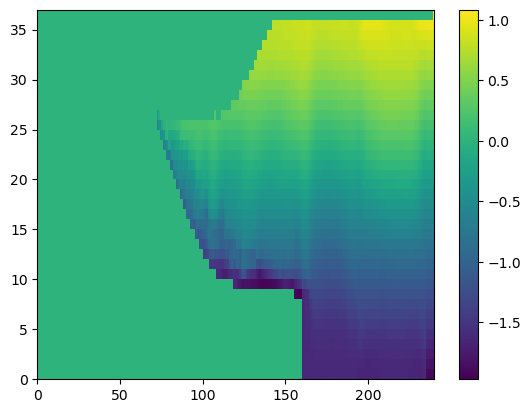

In [131]:
bin_file = 'Theta.bin'
nx = 24*10    # number of gridpoints in x-direction
ny = 21*2    # number of gridpoints in y-direction
nz = 37
h = np.fromfile('/home/156/cy8964/MITgcm/verification/ocean1/run2/'+bin_file, '>f4').reshape(nz, ny, nx)
plt.pcolormesh(h[:,10,...])
plt.colorbar()